Our portfolio:
('mean return:', 0.00035190296512490693)
('std return:', 0.0070803413628732553)
('sharpe ratio', 0.7570293578569669)
('cumulative return', 1.0787525999999974)

Market:
('mean return:', -8.7095737493291688e-05)
('std return:', 0.014827615975091885)
('sharpe ratio', -0.089468377971352653)
('cumulative return', 0.95519770408163196)


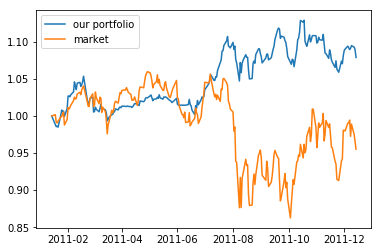

In [5]:
import pandas as pd
import numpy as np
import math
import copy
import QSTK.qstkutil.qsdateutil as du
import datetime as dt
import QSTK.qstkutil.DataAccess as da
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkstudy.EventProfiler as ep
import matplotlib.pyplot as plt


class performance:
    def __init__(self,order_path,market_sym,init_cash):
        self.market_sym = market_sym
        self.init_cash = init_cash
        ## data collecting
        self.orders,self.start_date,self.end_date = self.read_order(order_path)
        symbols = list(set(self.orders['sym']))
        prices,market_prices = self.get_relevant_stock_data(self.start_date,self.end_date,symbols,self.market_sym)
        self.symbols = prices.columns.values

        ## initialize allocation
        
        self.allocation = np.zeros((len(prices),len(self.symbols)))
        self.cash_account = self.generate_allocation(self.init_cash,
                                                     self.allocation,
                                                     self.orders,
                                                     prices,
                                                     list(prices.index.values),
                                                     self.symbols)

        self.self_performance,self.market_performance = self.analyze(self.cash_account,
                                                                     self.allocation,
                                                                     prices,
                                                                     market_prices)
        self.dates = [self.numpy64date_to_timestamp(d) for d in prices.index.values]
        
    def read_order(self,path):
        df = pd.read_csv(path,sep=",",header=None)
        df.columns = ['year','month','date','sym','type','shares','crap']
        del df['crap']
        datetime = []
        for i in range(0,len(df)):
            row = df.iloc[i]
            datetime.append(dt.datetime(row['year'],row['month'],row['date']))
        df['datetime'] = datetime
        df.sort_values('datetime',inplace=True)
        df.drop(['year','month','date'],inplace=True,axis=1)
        datetime = list(df['datetime'])
        start_date = datetime[0]
        end_date = datetime[-1]+dt.timedelta(days=1)
        df = df.reset_index()
        return df,start_date,end_date

    def get_relevant_stock_data(self,start_date,end_date,ls_symbols,market_sym):
        ldt_timestamps = du.getNYSEdays(start_date, end_date, dt.timedelta(hours=16))

        dataobj = da.DataAccess('Yahoo')

        ls_symbols.append(market_sym)

        ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
        ldf_data = dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
        d_data = dict(zip(ls_keys, ldf_data))

        for s_key in ls_keys:
            d_data[s_key] = d_data[s_key].fillna(method='ffill')
            d_data[s_key] = d_data[s_key].fillna(method='bfill')
            d_data[s_key] = d_data[s_key].fillna(1.0)
        prices = d_data['close']
        market_prices = prices.loc[:,market_sym]
        market_prices.columns = [market_sym]
        prices.drop([market_sym],inplace=True,axis=1)
        return prices,market_prices

    def numpy64date_to_timestamp(self,x):
        return dt.datetime.utcfromtimestamp(x.tolist()/1e9).replace(hour=0, minute=0, second=0, microsecond=0)

    def generate_allocation(self,init_cash,allocation,orders,prices,dates,symbols):
        sym_dict = {name: index for index, name in enumerate(symbols)}
        next_order = 0
        next_order_date = orders['datetime'][next_order]
        i = 0
        cash = np.zeros(len(dates))
        cash[0] = init_cash
        while i < len(dates):
            date = self.numpy64date_to_timestamp(dates[i])
            if i > 0:
                allocation[i,:] = allocation[i-1,:]
                cash[i] = cash[i-1]
            while (date == next_order_date and next_order <= len(orders)-1):
                sym = orders['sym'][next_order]
                Buy_Sell = orders['type'][next_order]
                share = orders['shares'][next_order]
                if Buy_Sell == 'Sell':
                    share = share*(-1)
                allocation[i,sym_dict[sym]] = share + allocation[i,sym_dict[sym]]
                cash[i]  -= share*prices[sym].iloc[i]
                next_order += 1
                if next_order <= len(orders)-1:
                    next_order_date = orders['datetime'][next_order] 
            #print dates[i], cash[i],allocation[i,:]
            i += 1
        #print(cash,allocation)
        return cash

    def analyze(self,cash_account,allocation,prices,market_prices):
        prices = prices.values
        stock_account = np.sum(prices*allocation,axis=1)
        wealth = cash_account+stock_account

        wealth_ret = tsu.returnize0(wealth)
        mean_ret = np.mean(wealth_ret)
        std_ret = np.std(wealth_ret)
        sharpe_ratio = 1.0*np.sqrt(len(wealth_ret))*mean_ret/std_ret
        cum_ret = np.cumprod(1+wealth_ret)[-1]

        market_ret = tsu.returnize0(market_prices)
        mean_ret_market = np.mean(market_ret)
        std_ret_market = np.std(market_ret)
        sharpe_ratio_market = 1.0*np.sqrt(len(market_ret))*mean_ret_market/std_ret_market
        cum_ret_market = np.cumproduct(1+market_ret)[-1]

        print("Our portfolio:")
        print("mean return:",mean_ret)
        print("std return:",std_ret)
        print("sharpe ratio",sharpe_ratio)
        print("cumulative return",cum_ret)
        print("")
        print("Market:")
        print("mean return:",mean_ret_market)
        print("std return:",std_ret_market)
        print("sharpe ratio",sharpe_ratio_market)
        print("cumulative return",cum_ret_market)   

    
        self.self_performance = {'mean_ret':mean_ret,'std_ret':std_ret,
                                 'sharpe_ratio':sharpe_ratio,'cum_ret':cum_ret,
                                'cum_ret_series':np.cumprod(1+wealth_ret)}
        self.market_performance = {'mean_ret':mean_ret_market,'std_ret':std_ret_market,
                                   'sharpe_ratio':sharpe_ratio_market,'cum_ret':cum_ret_market,
                                  'cum_ret_series':np.cumproduct(1+market_ret)}
        return self.self_performance,self.market_performance

    def draw(self):
        plt.plot(self.dates,self.self_performance['cum_ret_series'],label='our portfolio')
        plt.plot(self.dates,self.market_performance['cum_ret_series'],label='market')
        plt.legend()
        plt.show()
        
## set initial variables
path = 'Orders-files/orders2.csv'
market_sym = 'SPY'
init_cash = 1000000

result = performance(path,market_sym,init_cash)
result.draw()
our_performance,market_performance = result.self_performance,result.market_performance




datetime.datetime(2011, 1, 14, 16, 0)